# Looking to analyze ripples during cat/FR when the same category is reinstated during encoding

In [213]:
import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
from ptsa.data.filters import ButterworthFilter
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from copy import copy
from scipy import stats
import pickle
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/Downloads/ptsa_plot-master/')
sys.path.append('/home1/john/johnModules')
from brain_labels import MTL_labels, LTC_labels, PFC_labels, OTHER_labels, ALL_labels # all location labels
%load_ext autoreload
%autoreload
from general import *
from SWRmodule import *

import seaborn as sb

df = get_data_index("r1") # all RAM subjects
exp = 'catFR1' # 'FR1' 'catFR1'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [190]:
subs = ['R1207J'] #['R1108J'] # R1065J # 'R1035M'

sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp)] # all sessions for subs
# sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp) & (df.session==1)] # single session
# sub_df = df[(df.experiment == exp) & (df.session == 0)] # all FR subs 
# sub_df = sub_df[0:1]
sub_df

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
1193,NaN,protocols/r1/subjects/R1207J/experiments/catFR...,protocols/r1/subjects/R1207J/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1207J/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1207J/localizations/0/m...,NaN,0,R1207J,R1207J,2.0,protocols/r1/subjects/R1207J/experiments/catFR...
1194,NaN,protocols/r1/subjects/R1207J/experiments/catFR...,protocols/r1/subjects/R1207J/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1207J/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1207J/localizations/0/m...,NaN,1,R1207J,R1207J,2.0,protocols/r1/subjects/R1207J/experiments/catFR...
1195,NaN,protocols/r1/subjects/R1207J/experiments/catFR...,protocols/r1/subjects/R1207J/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1207J/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1207J/localizations/0/m...,NaN,2,R1207J,R1207J,2.0,protocols/r1/subjects/R1207J/experiments/catFR...
1196,NaN,protocols/r1/subjects/R1207J/experiments/catFR...,protocols/r1/subjects/R1207J/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1207J/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1207J/localizations/0/m...,NaN,3,R1207J,R1207J,2.0,protocols/r1/subjects/R1207J/experiments/catFR...


In [247]:
# 575 FR sessions. first 18 of don't load so skip those 
exp_df = df[df.experiment==exp]
if exp == 'FR1':
    exp_df = exp_df[
                    ((df.subject!='R1015J') | (df.session!=0)) & 
                    ((df.subject!='R1063C') | (df.session!=1)) & 
                    ((df.subject!='R1093J') | (~df.session.isin([1,2]))) &
                    ((df.subject!='R1100D') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1120E') | (df.session!=0)) &
                    ((df.subject!='R1122E') | (df.session!=2)) &
                    ((df.subject!='R1154D') | (df.session!=0)) &
                    ((df.subject!='R1186P') | (df.session!=0)) &
                    ((df.subject!='R1201P') | (~df.session.isin([0,1]))) &
                    ((df.subject!='R1216E') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1277J') | (df.session!=0)) &
                    ((df.subject!='R1413D') | (df.session!=0)) & 
                    ((df.subject!='R1123C') | (df.session!=2)) & # artifacts that bleed through channels (see SWR FR1 prob sessions ppt)
                    ((df.subject!='R1151E') | (~df.session.isin([1,2]))) & # more bleed-through artifacts (see same ppt)
                    ((df.subject!='R1275D') | (df.session!=3))  # 3rd session an actual repeat of 2nd session (Paul should have removed from database by now)
    #                 (df.subject!='R1065J') # sub with 9000 trials
                   ] 
if exp == 'catFR1': 
    exp_df = exp_df[
                    ((df.subject!='R1044J') | (df.session!=0)) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1491T') | (~df.session.isin([1,3,5]))) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1486J') | (~df.session.isin([4,5,6,7]))) & # repeated data...will be removed at some point... @@
                    ((df.subject!='R1501J') | (~df.session.isin([0,1,2,3,4,5]))) & # these weren't catFR1 (and they don't load right anyway)
                    ((df.subject!='R1235E') | (df.session!=0)) & # split EEG filenames error...documented on Asana
                    ((df.subject!='R1310J') | (df.session!=1)) & # session 1 is just a repeat of session 0
                    ((df.subject!='R1239E') | (df.session!=0)) # some correlated noise (can see in catFR1 problem sessions ppt)
    ]
exp_df.shape
# exp_df = exp_df[257:] # for catFR1 this is R1385E-onwwards
# exp_df = exp_df[472:] # for FR1 this is R1385E-onwwards
# exp_df = exp_df[:50]
exp_df

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(572, 17)

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
24,NaN,protocols/r1/subjects/R1004D/experiments/catFR...,protocols/r1/subjects/R1004D/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1004D/experiments/catFR...,0,NaN,0,protocols/r1/subjects/R1004D/localizations/0/m...,NaN,0,R1004D,R1004D,NaN,protocols/r1/subjects/R1004D/experiments/catFR...
45,NaN,protocols/r1/subjects/R1013E/experiments/catFR...,protocols/r1/subjects/R1013E/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1013E/experiments/catFR...,1,NaN,0,protocols/r1/subjects/R1013E/localizations/0/m...,NaN,0,R1013E,R1013E_1,NaN,protocols/r1/subjects/R1013E/experiments/catFR...
58,NaN,protocols/r1/subjects/R1015J/experiments/catFR...,protocols/r1/subjects/R1015J/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1015J/experiments/catFR...,0,NaN,0,protocols/r1/subjects/R1015J/localizations/0/m...,NaN,0,R1015J,R1015J,NaN,protocols/r1/subjects/R1015J/experiments/catFR...
64,NaN,protocols/r1/subjects/R1016M/experiments/catFR...,protocols/r1/subjects/R1016M/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1016M/experiments/catFR...,0,NaN,0,protocols/r1/subjects/R1016M/localizations/0/m...,NaN,0,R1016M,R1016M,NaN,protocols/r1/subjects/R1016M/experiments/catFR...
65,NaN,protocols/r1/subjects/R1016M/experiments/catFR...,protocols/r1/subjects/R1016M/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1016M/experiments/catFR...,0,NaN,1,protocols/r1/subjects/R1016M/localizations/0/m...,NaN,1,R1016M,R1016M,NaN,protocols/r1/subjects/R1016M/experiments/catFR...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2853,NaN,protocols/r1/subjects/R1665J/experiments/catFR...,protocols/r1/subjects/R1665J/localizations/0/m...,catFR1,build,0,NaN,0,NaN,NaN,protocols/r1/subjects/R1665J/localizations/0/m...,NaN,2,R1665J,R1665J,4.0,protocols/r1/subjects/R1665J/experiments/catFR...
2854,NaN,protocols/r1/subjects/R1666S/experiments/catFR...,protocols/r1/subjects/R1666S/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1666S/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1666S/localizations/0/m...,NaN,0,R1666S,R1666S,3.4,protocols/r1/subjects/R1666S/experiments/catFR...
2855,NaN,protocols/r1/subjects/R1666S/experiments/catFR...,protocols/r1/subjects/R1666S/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1666S/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1666S/localizations/0/m...,NaN,2,R1666S,R1666S,3.4,protocols/r1/subjects/R1666S/experiments/catFR...
2856,NaN,protocols/r1/subjects/R1666S/experiments/catFR...,protocols/r1/subjects/R1666S/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1666S/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1666S/localizations/0/m...,NaN,4,R1666S,R1666S,3.4,protocols/r1/subjects/R1666S/experiments/catFR...


# Load CLUSTER data

In [261]:
## Now to load data from cluster, have to go through and append across sessions

### params that clusterRun used (note that exp is defined in first cell so can get exp_df above)

selected_period = 'encoding'
# 'whole_encoding': aligned to 1st word of each encoding period and ends 29.7 s later (average time for 12 words to be shown)
# 'encoding': aligned to word_on

recall_type_switch = 0

recall_minimum = 2000 # used if recall_type_switch = 3
region_name = 'ENTPHC' #'ENT' #'HPC' #HPC_ENT #ENT #HPC # PHC # nonHPC_MTL
remove_soz_ictal = 0 # 0 for nothing, 1 for remove SOZ, 2 for keep ONLY SOZ ###
filter_type = 'hamming' # butter/hamming/hamming125200/tried hamming140250 for math
sub_selection = 'whole' # 'second_half', 'whole' ,'first_half'
                              # analyze first 40%, remaining 60% of data, or whole? 
                              # works for FR1 and catFR1
###

# get strings for path name for save and loading cluster data
if recall_type_switch in [0,4,6,8]:
    # for these I'm using all trials, but selecting for which recall after the fact
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,0,selected_period,recall_minimum)
else: # these others I haven't set up indexing (see >line 100 in this cell)
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
    
ripple_array = []; HFA_array = [] 
trial_nums = []; encoded_word_key_array = []
HPC_names = []; sub_sess_names = []
region_electrode_ct = []; sub_names = []
trial_by_trial_correlation = []; elec_ripple_rate_array = []
elec_by_elec_correlation = []; fr_array = []
list_num_key = []; category_array = [] # need these two to analyze categories during encoding

serialpos_array = []; list_recall_num_array = []; # ~~~
rectime_array = []; recall_before_intrusion_array = []
recall_position_array = []
semantic_clustering_key = []; temporal_clustering_key = []
session_events = pd.DataFrame()

electrode_labels = []; channel_coords = []; channel_nums = []

analysis_df = getSplitDF(exp_df,sub_selection,exp,selected_period)

for row in analysis_df.itertuples(): #analysis_df.itertuples(): #sub_df.itertuples():  #analysis_df.itertuples(): 
    try:
        sub = row.subject; session = row.session; exp = row.experiment
            
        path_name = '/scratch/john/SWR_semantic_scratch/'+subfolder
#         path_name = '/scratch/john/SWR_semantic_scratch/ENCODING/2023-03-14_working_files_prior_to_adding_HFA_clustering'

        fn = os.path.join(path_name,
            'SWR_'+exp+'_'+sub+'_'+str(session)+'_'+region_name+'_'+selected_period+recall_selection_name+
                          '_'+soz_label+'_'+filter_type+'.p') #'_no_param_removal.p')   #'.p') #+'.intrusions.p') # +'.-wrong.p') (for wrong math)
        with open(fn,'rb') as f:
            dat = pickle.load(f)

            ripple_array = superVstack(ripple_array,dat['ripple_array']) 
            HFA_array = superVstack(HFA_array,dat['HFA_array'])
            
            region_electrode_ct.append(dat['region_electrode_ct'])
            encoded_word_key_array.extend(dat['encoded_word_key_array'])
            HPC_names.extend(dat['HPC_names'])
            sub_sess_names.extend(dat['sub_sess_names'])
            sub_names.extend(dat['sub_names'])
            trial_nums = np.append(trial_nums,dat['trial_nums'])
            trial_by_trial_correlation.extend(dat['trial_by_trial_correlation']) # one value for each electrode for this session
            elec_by_elec_correlation = np.append(elec_by_elec_correlation,dat['elec_by_elec_correlation'])
            elec_ripple_rate_array.extend(dat['elec_ripple_rate_array']) # ripple rate by electrode so append
            #,'total_recalls':total_recalls, 'kept_recalls':kept_recalls}, f)
            session_events = session_events.append(dat['session_events']) # doesn't append in place 
            
            # specific to whole_encoding
            serialpos_array.extend(dat['serialpos_array'])
            recall_position_array.extend(dat['recall_position_array']) # 1-indexed
            list_recall_num_array.extend(dat['list_recall_num_array'])
            
            electrode_labels.extend(dat['electrode_labels'])
            channel_coords.extend(dat['channel_coords'])
#             channel_nums.extend(dat['channel_nums']) # no channel_nums in Clustering code for whatever reason
            list_num_key.extend(dat['list_num_key'])
            if exp == 'catFR1':
                category_array.extend(dat['category_array'])
                semantic_clustering_key.extend(dat['semantic_clustering_key'])
            elif exp == 'FR1':
                temporal_clustering_key.extend(dat['temporal_clustering_key'])
            
    except Exception as e:
        LogDFExceptionLine(row, e, 'ClusterLoadSWR_log.txt')  
print('**Done reading data**')
        
## loading *all* the recalls with 0, but if it's 4 or 6 load just those trials

# trying new method of loading...translate these to ripple_array length dependent on recall_type_switch 
# (this way I can always load from recall_type_switch = 0)

subject_name_array,session_name_array,electrode_array,channel_coords_array = getSubSessPredictors(
        sub_names,sub_sess_names,trial_nums,electrode_labels,channel_coords)

# spread out encoded_word_key too so I know which words were correct
word_correct_array = []
for sess_elec in encoded_word_key_array:
    word_correct_array.extend(sess_elec)
word_correct_array = np.array(word_correct_array)
word_correct_array[word_correct_array>0] = 1 # 1s and 2s are corrects

# serialpos too!
sp_array = []
for sp in serialpos_array:
    sp_array.extend(sp)
serialpos_array = sp_array

# this is same as word_correct_array just 0/1/2 instead of 0/1s
temp = []
for enc in encoded_word_key_array:
    temp.extend(enc)
encoded_word_key_array = copy(temp)


# temp_recall_idxs = np.array(list_recall_num_array)>=0 # just keep them all
    
# subject_name_array = np.array(subject_name_array)[temp_recall_idxs]
# session_name_array = np.array(session_name_array)[temp_recall_idxs]
# electrode_array = np.array(electrode_array)[temp_recall_idxs]
# channel_coords_array = np.array(channel_coords_array)[temp_recall_idxs]
# channel_nums_array = np.array(channel_nums_array)[temp_recall_idxs]
# ripple_array = np.array(ripple_array)[temp_recall_idxs]
# rectime_array = np.array(rectime_array)[temp_recall_idxs]
# list_recall_num_array = np.array(list_recall_num_array)[temp_recall_idxs]
# recall_position_array = np.array(recall_position_array)[temp_recall_idxs]
    
print('**Done translating to ripple_array frame**!!')
print('...')
    
## some info on data loaded from cluster runs ##
ripple_array.shape
HFA_array.shape

region_electrode_ct = np.array(region_electrode_ct)
# print('Number of electrodes in each session: '); region_electrode_ct
print('From '+str(sum(region_electrode_ct>0))+'/'+str(len(region_electrode_ct))+' sessions with >0 '+region_name+' electrodes')
print('Total trials: '+str(int(np.sum(trial_nums))))
print('Unique sessions: '+str(len(np.unique(sub_sess_names))))
print('...from '+str(len(np.unique(subject_name_array)))+' patients')

# some info about regions 
sub_elec = [subject_name_array[i]+electrode_array[i] for i in range(len(electrode_array))]
print('Number of electrodes: '+str(len(np.unique(sub_elec))))

print('Electrode regions X sessions:')
unique_names = np.unique(HPC_names)
for name in unique_names:
    num_elecs = sum(np.array([names.find(name) for names in HPC_names])>=0)
    print(str(num_elecs)+' for '+name)
    

[]
[]
2023-04-07_20-36-25: DF Exception: Sub: R1004D, Sess: 0, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_semantic_scratch/ENCODING/SWR_catFR1_R1004D_0_ENTPHC_encoding_soz_in_hamming.p', file: <ipython-input-261-c6b71d8737ea>, line no: 55
2023-04-07_20-36-25: DF Exception: Sub: R1092J, Sess: 0, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_semantic_scratch/ENCODING/SWR_catFR1_R1092J_0_ENTPHC_encoding_soz_in_hamming.p', file: <ipython-input-261-c6b71d8737ea>, line no: 55
2023-04-07_20-36-26: DF Exception: Sub: R1190P, Sess: 0, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_semantic_scratch/ENCODING/SWR_catFR1_R1190P_0_ENTPHC_encoding_soz_in_hamming.p', file: <ipython-input-261-c6b71d8737ea>, line no: 55
2023-04-07_20-36-26: DF Exception: Sub: R1207J, Sess: 2, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_semantic_scratch/ENCODING/SWR_catFR1_R1207J_2_ENTPHC_encoding_soz_i

(38304, 1500)

(38304, 30)

From 96/269 sessions with >0 ENTPHC electrodes
Total trials: 38304
Unique sessions: 96
...from 52 patients
Number of electrodes: 116
Electrode regions X sessions:
63 for  left ent entorhinal area
16 for  left phg parahippocampal gyrus
26 for  right ent entorhinal area
14 for  right phg parahippocampal gyrus
25 for "phc"
106 for entorhinal
4 for left ec
65 for left ent entorhinal area
3 for left phc
27 for left phg parahippocampal gyrus
63 for parahippocampal
2 for right ec
8 for right phc
17 for right phg parahippocampal gyrus


In [161]:
# to get total patient count including all regions
# HPC_subs = np.unique(subject_name_array)
# nonHPC_subs = np.unique(subject_name_array)
# test = np.append(HPC_subs,nonHPC_subs)
# np.unique(test)
# len(np.unique(test))
# total patients is 129
# HPC is 252 sessions from 126 patients (checked and amazingly only 3 without HPC...catFR mostly sEEG I suppose)
# nonHPC_MTL is 191 sessions from 95 patients

# DG_new_subs = np.unique(subject_name_array)
# DG_new_sess = np.unique(session_name_array)

# list(set(DG_old_subs) - set(DG_new_subs))
# list(set(DG_old_sess) - set(DG_new_sess))

len(HFA_array)
len(ripple_array)
len(electrode_array)
len(list_num_key)
len(word_correct_array)
len(recall_position_array)
len(serialpos_array)
len(encoded_word_key_array)
len(semantic_clustering_key)
len(category_array)
len(temporal_clustering_key)
len(session_name_array)
print('was 243670 with HPC before adding HFA')

63691

63691

63691

63691

63691

63691

63691

63691

63691

63691

0

63691

was 243670 with HPC before adding HFA


(2244, 1500)


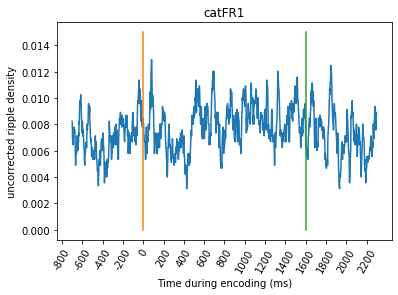

In [17]:
print(np.shape(ripple_array))
plot(np.mean(ripple_array,0))
if selected_period == 'whole_encoding':
    xticks(range(0,20000,2500),range(0,40000,5000))
    plot([1000,1000],[0,0.015])    
elif selected_period == 'encoding':
    xticks(ticks=range(-350,1501,100),labels=range(-1400,3001,200),rotation=60)
    plot([350,350],[0,0.015])
    plot([1150,1150],[0,0.015])   
elif selected_period == 'whole_retrieval':
    xticks(ticks=range(0,17001,2500),labels=range(0,32001,5000),rotation=60)
    plot([1000,1000],[0,0.015]) 
    plot([1000+15000,1000+15000],[0,0.015]) 
# ylim(0,0.015)
title(exp)
ylabel('uncorrected ripple density')
xlabel('Time during encoding (ms)');

# Get start_array and select subfield if HPC for free recalls

In [262]:
## DO YOU WANT TO SELECT A SUBFIELD or OUTPUT POSITION?? ##  

select_subfield = False   # note: if you already ran this once, have to load again from data
                          # also this is only for HPC. So set to False for ENT and PHC
    
# select for subfield if HPC
if select_subfield == True:
    location_selected = ['ca1','dg'] #'dg' # 'ca3' # 'dg' 'ca1' # sub # ['ca1','dg']
        # left # right # left hippocampus # right hippocampus # hippocampus
        # to see number of each: sum(np.array([names.find('sub') for names in HPC_names])>=0)
else:
    location_selected = ''
    

### Use a task condition to select recalls?? ###
### ...will select first one that's not 0    ###
select_ordinal_position = 0              # select only recalls at given output position. 0 means it's off ##DEPRECATED
select_less_than_rectime = 0             # select only recalls < this number % 5000
select_greater_than_rectime = 0          # select only recalls ≥ this number % 5000
select_lists_with_recalls = 0 # list(np.arange(3,13)) # [1] so this would select ≥4 recalls. Must be list hence the list(arange...)
                                         # select only recalls that come from lists with number in this list
select_intrusions_next = 0               # select recalls that lead to intrusions
    
if filter_type.find('hamming') != -1:
    desired_sample_rate = 500.
else:
    desired_sample_rate = 1000.
sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
sr_factor = 1000/desired_sample_rate

print('Total electrodes loaded: '+str(len(trial_nums)))
print('from '+str(len(np.unique(sub_sess_names)))+' sessions from '+str(len(np.unique(sub_names)))+' subjects with trial nums:')
print(trial_nums[0:20])
print('Trial sum = '+str(np.sum(trial_nums)))
print(HPC_names[0:20])
print('Number of sub_sess names: '+str(len(sub_sess_names)))


start_array,end_array = getStartEndArrays(ripple_array); print('Got encoding start_array!')
 
# if selected an output position
if select_ordinal_position > 0:
    if np.min(ordinal_position_array) == 0: # only update this once (so don't have to reload data from files)
        ordinal_position_array = np.array(ordinal_position_array)+1 # now 1-indexed
    selected_recalls = ordinal_position_array==select_ordinal_position
elif select_intrusions_next == 1:
    selected_recalls = np.array(recall_before_intrusion_array)==True
elif select_less_than_rectime > 0:
    selected_recalls = np.array(rectime_array)<select_less_than_rectime
elif select_greater_than_rectime > 0:
    selected_recalls = np.array(rectime_array)>=select_greater_than_rectime
elif ( (type(select_lists_with_recalls) == list) | (isinstance(select_lists_with_recalls, np.ndarray)) ):    
    selected_recalls = [recall in select_lists_with_recalls for recall in list_recall_num_array]
else:
    selected_recalls = np.ones(len(start_array),dtype=bool)
    
# get locations if selected

if select_subfield == True:
    # create the full vector of location name predictors
    location_names = []
    for s in range(len(HPC_names)):
        new_trials = int(trial_nums[s])
        location_names.extend(np.tile(HPC_names[s],new_trials))  
        
    # now can get mask of trials in this location
    
    #first, if there are two locations to combine, sort that out (DG and CA1 in particular)
    location_mask = np.zeros(len(location_names))
    for s in range(len(location_names)):
        if type(location_selected)==list:
            if location_names[s].find(location_selected[0])>=0 or location_names[s].find(location_selected[1])>=0:
                location_mask[s] = True
        elif type(location_selected)==str:
            if location_names[s].find(location_selected)>=0:
                location_mask[s] = True
else:
    location_mask = np.ones(len(start_array))

# DON'T USE temp_recall_idxs FOR ENCODING
# # gotta translate this to new frame as well from idxs in load step if selected subfield
# if select_subfield == True: 
#     location_mask = location_mask[temp_recall_idxs] 

# combine location and sorted recalls to get new ripple array:
updated_recalls = (location_mask+selected_recalls)==2

# these lists did not have 12 word presentations, so remove them
if exp == 'catFR1':
    updated_recalls[(np.array(session_name_array)=='R1180C-2') & (np.array(list_num_key)==24)] = 0
    updated_recalls[(np.array(session_name_array)=='R1278E-10') & (np.array(list_num_key)==25)] = 0
    
    
# translate these predictors to vector and select recalls
start_array = start_array[updated_recalls]
end_array = end_array[updated_recalls] # used for duration calculations
subject_name_array = np.array(subject_name_array)[updated_recalls]
session_name_array = np.array(session_name_array)[updated_recalls]
electrode_array = np.array(electrode_array)[updated_recalls]
channel_coords_array = np.array(channel_coords_array)[updated_recalls]
# channel_nums_array = np.array(channel_nums_array)[updated_recalls]

# if selected_period in ['surrounding_recall','math','math_retrieval']:
#     list_recall_num_array = list_recall_num_array[updated_recalls] # for subject-level analysis
# rectime_array = np.array(rectime_array)[updated_recalls]
# recall_position_array = np.array(recall_position_array)[updated_recalls]

# specific to encoding
# serialpos_array = np.array(serialpos_array)[updated_recalls] # FIX THIS ONCE RUN AGAIN 2021-09-16
# specific to whole_encoding
# list_recall_num_array = np.array(list_recall_num_array)[updated_recalls]

encoded_word_key_array = np.array(encoded_word_key_array)[updated_recalls]
serialpos_array = np.array(serialpos_array)[updated_recalls]
list_num_key = np.array(list_num_key)[updated_recalls]
word_correct_array = word_correct_array[updated_recalls]
recall_position_array = np.array(recall_position_array)[updated_recalls]
session_events = session_events[updated_recalls]

HFA_array = HFA_array[updated_recalls,:]

if exp == 'catFR1':   
    category_array = np.array(category_array)[updated_recalls]
    semantic_clustering_key = np.array(semantic_clustering_key)[updated_recalls]
elif exp == 'FR1':
    temporal_clustering_key = np.array(temporal_clustering_key)[updated_recalls]
    
print('Got start_array with '+str(start_array.shape[0])+' trials!')

sub_elec = [subject_name_array[i]+electrode_array[i] for i in range(len(electrode_array))]
print('Number of electrodes: '+str(len(np.unique(sub_elec))))
print('...from '+str(len(np.unique(subject_name_array)))+' patients')
        
# # plot whole retrieval period with FR events superimposed on SWRs
# if selected_period == 'whole_bretrieval':
#     start_array2 = start_array # for whole retrieval period
#     print('Base SWRs/30 s retrieval: '+str(sum(start_array2)/start_array2.shape[0]/(30000/1000)))
#     ## can go straight to "SWRs by time in retrieval period" from here
# else:
#     print('SWRs rate in 4 s around FR: '+str(sum(start_array)/start_array.shape[0]/(4000/1000)))

# # subplots(1,1,figsize=(6,9))
# # plot([0,0],[0,fr_array.shape[0]],linewidth=1,linestyle='-',color=(0,0,0))
# # plot(np.ones(2)*(retrieval_whole_time),[0,fr_array.shape[0]],linewidth=1,linestyle='-',color=(0,0,0))
# # scatter(np.where(start_array2)[1]*sr_factor+psth_start,np.where(start_array2)[0],s=0.5)
# # scatter(np.where(fr_array)[1],np.where(fr_array)[0],s=0.5,color=[1,0,0]); 
# # plt.xlabel('Retrieval period time (ms)')
# # plt.ylabel('Retrieval period')
# # if save_plot == 1:
# #     plt.savefig('../plots/'+'SWR_FR_'+region_name+'-'+str(session_ct)+'_sessions_in-'+str(sub_num)+'subjects_'+filter_type+'.pdf',transparent=True)
# # plt.show();    

print('# of trials: '+str(np.shape(start_array)[0]))
print('Total # of ripples: '+str(sum(start_array)))
print('Overall ripple rate: '+str(np.round( (1000/sr_factor)*sum(start_array)/np.shape(start_array)[0]/np.shape(start_array)[1],3 ))+' Hz')

Total electrodes loaded: 211
from 96 sessions from 52 subjects with trial nums:
[120. 300. 300. 300. 300. 300. 300. 300. 300. 300. 300. 300. 300. 300.
 132. 132. 132. 132. 132. 132.]
Trial sum = 38304.0
['left ec', 'entorhinal', 'parahippocampal', 'parahippocampal', 'entorhinal', 'parahippocampal', 'parahippocampal', 'parahippocampal', 'left phg parahippocampal gyrus', 'entorhinal', 'parahippocampal', 'left ec', 'parahippocampal', 'right phg parahippocampal gyrus', 'entorhinal', 'parahippocampal', 'left ec', 'parahippocampal', 'right phg parahippocampal gyrus', 'parahippocampal']
Number of sub_sess names: 211
Got encoding start_array!
Got start_array with 38304 trials!
Number of electrodes: 116
...from 52 patients
# of trials: 38304
Total # of ripples: 26577
Overall ripple rate: 0.231 Hz


In [8]:
len(ripple_array)
len(electrode_array)
len(list_num_key)
len(word_correct_array)
len(recall_position_array)
len(serialpos_array)
len(encoded_word_key_array)
len(semantic_clustering_key)
len(category_array)
len(temporal_clustering_key)
len(session_name_array)

241894

97872

97872

97872

97872

97872

97872

97872

97872

0

97872

# SCE (Subsequent Clustering Effect?)

## semantic clustering for catFR

In [263]:
# select which serialpositions you're looking at (since curious if 1-6 show all the SCE)
serialpos_select = np.arange(1,13) #np.arange(1,7) # np.arange(1:13)


remove_chaining = 0 # 2022-07-19 trying a control to see if SCE still exists after removing recalls that begin with SP 1+2 in a row


# these values are all for subject-level SCE v. avg_recalls analysis
if sub_selection == 'whole':
    min_SCE_trials = 20 # minimum SCE trials in session to include in SCE v. avg_recalls plot
elif sub_selection == 'second_half':
    min_SCE_trials = 10

# just divide all these by 100 for HFA since it's already in 100 ms bins
encoding_time = 23 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms
pre_encoding_time = -7
ripple_bin_start_end = [4,11] # range I'm going to look for ripples for regression of serialpos and category predictors
psth_start = -7
psth_end = 23
sr_factor = 1 # already have 30 bins with 100 ms bins

stats_bin = ripple_bin_start_end[1]-ripple_bin_start_end[0] # only using 1 bin for encoding 

adj_semantic_encoding_array = []
rem_semantic_encoding_array = []
rem_unclustered_encoding_array = []
last_recall_encoding_array = [] # the last word remembered on each list (no transitions)...but make sure it's not an intrusion or repeat too!
forgot_encoding_array = []
sub_name_array0 = []; sess_name_array0 = []; elec_name_array0 = []
sub_name_array1 = []; sess_name_array1 = []; elec_name_array1 = []
sub_name_array2 = []; sess_name_array2 = []; elec_name_array2 = []
sub_name_array3 = []; sess_name_array3 = []; elec_name_array3 = []
sess_name_array4 = [] # forgot why I keep the others but leaving them 2022-06-10
sub_name_array5 = []; sess_name_array5 = []; elec_name_array5 = []

# for clsutered v. unclustered subject-level analysis (need to record at session-level though for mixed model)

sess_sessions = []
sess_delta = []
sess_subjects = []
sess_recall_num = []
sess_clust_num = []
sess_prop_semantic = []

session_names = np.unique(session_name_array)

for sess in session_names:
    sess_list_nums = np.unique(list_num_key[session_name_array==sess]) 
    
    # for each session will get a clustered and unclustered start array to get the delta SCE
    start_arrayC = []; start_arrayU = []
    # and also the proportion of semantically clustered recalls
    temp_corr = []; temp_sem_key = []
        
    for ln in sess_list_nums:
        list_elec_array = np.unique(electrode_array[(session_name_array==sess) & (list_num_key==ln)])
        
        for elec in list_elec_array:
        
            list_ch_idxs = (session_name_array==sess) & (list_num_key==ln) & (electrode_array==elec)
            
            list_ch_encoding_array = HFA_array[list_ch_idxs]
            list_ch_cats = category_array[list_ch_idxs]
            list_ch_corr = word_correct_array[list_ch_idxs]
            list_ch_semantic_key = semantic_clustering_key[list_ch_idxs]
            list_ch_recall_positions = recall_position_array[list_ch_idxs]
            
            # remove ones starting with serialpos 1->2 as a control (or just 1 if it's len 1)
            if remove_chaining == 1:
                if len(list_ch_recall_positions[0])==1:
                    if list_ch_recall_positions[0][0]==1: # if 1st serialpos
                        continue # get out of this loop if only one recall and it's serialpos 1
                elif len(list_ch_recall_positions[0])>0:
                    if ((list_ch_recall_positions[0][0]==1)&(list_ch_recall_positions[0][1]==2)):     
                        continue # get out of loop if recalls are serialpos 1->2 (no matter what)            

            for i_recall_type,recall_type in enumerate(list_ch_semantic_key[0]): # all 12 words have same values so just take 1st one
                recall_position = list_ch_recall_positions[0][i_recall_type] # ditto re: taking 1st
                
                if recall_position in serialpos_select: # so can select by serialpos (e.g. 1:6 or 7:12)
                    if recall_type == 'A': # adjacent semantic
#                     if recall_type in ['A','C']: # adjacent AND remote semantic
                        # note the -1 since recall positions are on scale of 1-12
                        adj_semantic_encoding_array = superVstack(adj_semantic_encoding_array,list_ch_encoding_array[recall_position-1])
                        sub_name_array0.append(sess[0:6])
                        sess_name_array0.append(sess)
                        elec_name_array0.append(elec)
                    elif recall_type == 'C': # remote semantic
                        rem_semantic_encoding_array = superVstack(rem_semantic_encoding_array,list_ch_encoding_array[recall_position-1])
                        sub_name_array1.append(sess[0:6])
                        sess_name_array1.append(sess)
                        elec_name_array1.append(elec)
                    elif ( (recall_type == 'D') ): # & (recall_position>0) ): # remote unclustered
                        rem_unclustered_encoding_array = superVstack(rem_unclustered_encoding_array,list_ch_encoding_array[recall_position-1])
                        sub_name_array2.append(sess[0:6])
                        sess_name_array2.append(sess)  
                        elec_name_array2.append(elec)
                    elif ( (recall_type == 'Z') ): #& (recall_position>0) ): # last word of list & was actually a recalled word
                        last_recall_encoding_array = superVstack(last_recall_encoding_array,list_ch_encoding_array[recall_position-1])
                        sub_name_array3.append(sess[0:6])
                        sess_name_array3.append(sess)
                        elec_name_array3.append(elec)
                    else:
                        sess_name_array4.append(sess[0:6])
                        
                # I also want to do an SCE v. avg_recall_num by subject analysis
                # to do this will combine A/C as SCE group and combine D/Z as control  
                
                if recall_position in serialpos_select: # so can select by serialpos (e.g. 1:6 or 7:12)

                    if recall_type in ['A','C']: # adjacent semantic or remote semantic
                        # note the -1 since recall positions are on scale of 1-12
                        start_arrayC = superVstack(start_arrayC,list_ch_encoding_array[recall_position-1])
                    elif ( (recall_type in ['D','Z']) & (recall_position>0) ): # remote unclustered or dead end (>0 means recalled word)
                        start_arrayU = superVstack(start_arrayU,list_ch_encoding_array[recall_position-1])
                        
                        
            # unpack semantic clustering key to trial level (only need to do once for one electrode)

            if elec == list_elec_array[0]:

                for word in range(sum(list_ch_idxs)): 

                    if (word+1) in list_ch_recall_positions[0]: # serial positions are 1-indexed so add 1 to check in list_ch_recall_positions
                        temp_corr.append(1)
                        # use index from serialpos to get clustering classification
                        if ((sess== 'R1108J-2')&(ln==25)): # single mistake shwos up
                            if word == 8:
                                temp_sem_key.append('A')
                            elif word == 9:
                                temp_sem_key.append('Z')
                        else: 
                            temp_sem_key.append(list_ch_semantic_key[0][list_ch_recall_positions[0].index(word+1)])
                    else:
                        temp_corr.append(0)
                        temp_sem_key.append('')                

    
            # make forgotten array to plot along with SCE too which is easy enough 
            forgotten_words = 1-np.array(list_ch_corr)
            if sum(forgotten_words)>0: # R1065 a whiz
                forgot_encoding_array = superVstack(forgot_encoding_array,np.array(list_ch_encoding_array)[findInd(forgotten_words),:])
                sub_name_array5.extend(np.tile(sess[0:6],int(sum(forgotten_words))))
                sess_name_array5.extend(np.tile(sess,int(sum(forgotten_words))))
                elec_name_array5.extend(np.tile(elec,int(sum(forgotten_words))))

    if ( (len(start_arrayC)>min_SCE_trials) & (len(start_arrayU)>min_SCE_trials) & (len(start_arrayC)!=1500) ): # last one in there for a len(1) start_arrayC

        # back at session-level record the delta, sub, sess, and avg_recall_num for *all* trials
        sess_sessions.append(sess)
        sess_subjects.append(sess[0:6])   

        # can just use list_elec_array to select only one electrode we know exists for this session (altho should be irrelevant when we average anyyway)
        sess_word_correct_array = word_correct_array[((electrode_array==list_elec_array[0]) & (session_name_array==sess))]
        sess_recall_num.append(12*sum(sess_word_correct_array)/len(sess_word_correct_array)) # *12 to convert to recall_num/list
        
        # while temp_sem_key is NOT in the same order as sess_word_correct_array, can use it anyway to get proportion of clustered recalls
#         if sum(temp_corr) == sum(sess_word_correct_array):
        sess_prop_semantic.append(sum([trial in ['A','C'] for trial in temp_sem_key])/sum(temp_corr))
#         else:
#             print('temp_sem_key must be messed up for '+sess+'!!')
#             print(sum(temp_corr))
#             print(sum(sess_word_correct_array))

        # calculate single delta ripples value for clust v. not clust for this session
        binned_stats_arrayC = start_arrayC[:,int((ripple_bin_start_end[0]-psth_start)/sr_factor):
                                               int((ripple_bin_start_end[1]-psth_start)/sr_factor)]
        binned_stats_arrayC = binBinaryArray(binned_stats_arrayC,stats_bin,sr_factor)
        binned_stats_arrayU = start_arrayU[:,int((ripple_bin_start_end[0]-psth_start)/sr_factor):
                                               int((ripple_bin_start_end[1]-psth_start)/sr_factor)]
        binned_stats_arrayU = binBinaryArray(binned_stats_arrayU,stats_bin,sr_factor)
        sess_delta.append(np.mean(binned_stats_arrayC)-np.mean(binned_stats_arrayU))
        
trial_nums = [len(sub_name_array0),len(sub_name_array1),len(sub_name_array2),len(sub_name_array3),len(sess_name_array4)]
print(trial_nums/sum(trial_nums))
                
a=1;

[0.20333681 0.21175331 0.20214509 0.1540295  0.22873529]


## SCE v. avg_recall_num (before we get to semantic clustering PVTHs)

Mixed model of ripple_rate ~ avg_recall_num at session-level


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


                 Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   delta_ripple_rate
No. Observations:     88        Method:               REML             
No. Groups:           51        Scale:                0.0082           
Min. group size:      1         Likelihood:           -27.5068         
Max. group size:      4         Converged:            Yes              
Mean group size:      1.7                                              
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     0.132    0.103  1.286 0.199 -0.069  0.334
avg_recall_num               -0.007    0.019 -0.386 0.699 -0.045  0.030
subject Var                   0.115                                    
subject x avg_recall_num Cov -0.013                                    
avg_recal

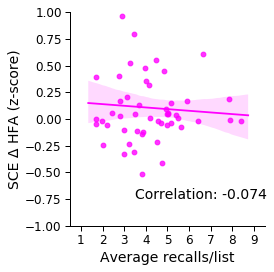

In [164]:
import seaborn as sb
import statsmodels.formula.api as smf

save_plot = 1
save_data_df = 1

sess_df = pd.DataFrame({'delta_ripple_rate':sess_delta,'avg_recall_num':sess_recall_num,
                        'session':sess_sessions,'subject':sess_subjects,'prop_semantic':sess_prop_semantic})
print('Mixed model of ripple_rate ~ avg_recall_num at session-level')         
vc = {'session':'0+session'}
sig_bin_model = smf.mixedlm("delta_ripple_rate ~ avg_recall_num", sess_df, groups="subject", vc_formula=vc,re_formula="avg_recall_num")
bin_model1 = sig_bin_model.fit(reml=True, method='nm',maxiter=2000) 
print(bin_model1.summary())
print(bin_model1.pvalues)
print(bin_model1.params)
print(bin_model1.bse_fe)

# want to plot at subject-level even though DF above is at subject_level
    
def defaultPlotting(): 
    sb.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white")

if location_selected == 'dg':
    min_rate = 0.1
    plot_color = [(0.8,0,0)]
    lmplot_color = (0.8,0,0,0)
    errorbar_color = (1,0.5,0.5)
    line_color = 'darkred'
elif location_selected == 'ca1':
    min_rate = 0.1 # for CA1 and DG I require a FR minimum for the two bins being compared since I do further stats on them
    plot_color = [(0,0,0.8)]
    lmplot_color = (0,0,0.8,0)
    errorbar_color = (0.5,0.5,1)
    line_color = 'darkblue'
elif region_name == 'nonHPC_MTL':
    lmplot_color = (1,0,1)
    line_color = (1,0,1)    

# convert session-level df to subject-level for plot
sub_delta = []
sub_recall_num = []
sub_prop_semantic = []
for sub in np.unique(sess_subjects):
    sub_delta.append(np.mean(np.array(sess_delta)[np.array(sess_subjects) == sub]))
    sub_recall_num.append(np.mean(np.array(sess_recall_num)[np.array(sess_subjects) == sub]))
    sub_prop_semantic.append(np.mean(np.array(sess_prop_semantic)[np.array(sess_subjects) == sub]))

set_pubfig()
deltaRR_df = pd.DataFrame({'avg_recall_num':sub_recall_num,'ripple_rates':sub_delta,'prop_semantic':sub_prop_semantic})
fig, ax = subplots(figsize=(4,4))
sb.regplot(ax=ax,x='avg_recall_num',y='ripple_rates',data=deltaRR_df,
         scatter_kws = {'color': lmplot_color},line_kws = {'color': line_color})

if exp == 'FR1':
    gca().set(ylim=(-0.31,0.31),xlim=(0.5,7.5))
    xticks(np.arange(1,7.5+0.01,1))
elif exp == 'catFR1':
    gca().set(ylim=(-1,1),xlim=(0.5,9.5))
    xticks(np.arange(1,9.5+0.01,1))
gca().tick_params(labelsize=12)

plot_corr = stats.pearsonr(sub_recall_num,sub_delta)

annotate('Correlation: '+str(np.round(plot_corr[0],3)),(3.5,-0.75)) 
# annotate('p-values: '+str(np.round(plot_corr[1],3)),(3.5,-0.29)) # use mixed model p-value instead:
# annotate('$\it{P}$-value: '+str(np.round(bin_model1.pvalues[1],3)),(3.5,-0.29))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)   
tight_layout()

ylabel(u'SCE Δ HFA (z-score)')
xlabel('Average recalls/list')
if type(location_selected)==list:
    location_selected = location_selected[0]+location_selected[1]
    
if save_plot == 1:
    if type(location_selected)==list:
        location_selected = 'ca1dg'
    fname = '/home1/john/SWR/figures/subject-level_plots/SCE_v_recall_'+exp+'_'+region_name+'_'+\
        location_selected+'_'+filter_type+'_'+sub_selection+'HFA.pdf'
    savefig(fname,format='pdf',transparent=True)
if save_data_df == 1:
    if type(location_selected)==list:
        location_selected = 'ca1dg'
    fname = '/home1/john/SWR/figures/subject-level_plots/SCE_v_recall_'+exp+'_'+region_name+'_'+\
        location_selected+'_'+filter_type+'_'+sub_selection+'HFA.p'
    with open(fname,'wb') as f:
        pickle.dump({'sess_df':sess_df}, f)
    
a=1;


## proportion of semantic recalls vs. SCE (make sure you run cell before first)

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
 

                Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   delta_ripple_rate
No. Observations:    88        Method:               REML             
No. Groups:          51        Scale:                0.0154           
Min. group size:     1         Likelihood:           -25.6546         
Max. group size:     4         Converged:            Yes              
Mean group size:     1.7                                              
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    0.098    0.125  0.782 0.434 -0.147  0.342
prop_semantic               -0.007    0.289 -0.023 0.982 -0.573  0.560
subject Var                  0.000    0.234                           
subject x prop_semantic Cov -0.000                                    
prop_semantic Var      

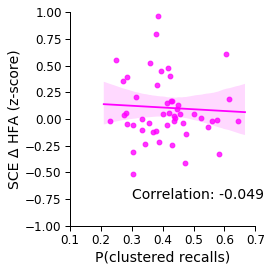

In [165]:
import seaborn as sb
import statsmodels.formula.api as smf

save_plot = 1

sig_bin_model2 = smf.mixedlm("delta_ripple_rate ~ prop_semantic", sess_df, groups="subject", vc_formula=vc,re_formula="prop_semantic")
bin_model2 = sig_bin_model2.fit(reml=True, method='nm',maxiter=2000) 
print(bin_model2.summary())
print(bin_model2.pvalues)
print(bin_model2.params)
print(bin_model2.bse_fe)

# want to plot at subject-level even though DF above is at subject_level
    
def defaultPlotting(): 
    sb.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white")

set_pubfig()
fig, ax = subplots(figsize=(4,4))
sb.regplot(ax=ax,x='prop_semantic',y='ripple_rates',data=deltaRR_df,
         scatter_kws = {'color': lmplot_color},line_kws = {'color': line_color})

xticks(np.arange(0,0.701,0.1))
if exp == 'FR1':
    gca().set(ylim=(-0.31,0.31),xlim=(0.5,7.5))
elif exp == 'catFR1':
    gca().set(ylim=(-1,1),xlim=(0.1,0.7))
gca().tick_params(labelsize=12)

plot_corr = stats.pearsonr(sub_prop_semantic,sub_delta)

if location_selected == 'ca1':
    annotate('Correlation: '+str(np.round(plot_corr[0],3)),(0.3,-0.75)) 
elif location_selected == 'dg':
    annotate('Correlation: '+str(np.round(plot_corr[0],3)),(0.3,-0.75))
else:
    annotate('Correlation: '+str(np.round(plot_corr[0],3)),(0.3,-0.75)) 
# annotate('p-values: '+str(np.round(plot_corr[1],3)),(3.5,-0.29)) # use mixed model p-value instead:
# annotate('$\it{P}$-value: '+str(np.round(bin_model1.pvalues[1],3)),(3.5,-0.29))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)   
tight_layout()

ylabel(u'SCE Δ HFA (z-score)')
xlabel('P(clustered recalls)')
if type(location_selected)==list:
    location_selected = location_selected[0]+location_selected[1]
    
if save_plot == 1:
    if type(location_selected)==list:
        location_selected = 'ca1dg'
    fname = '/home1/john/SWR/figures/subject-level_plots/SCE_v_clustered_recalls_'+exp+'_'+region_name+'_'+\
        location_selected+'_'+filter_type+'_'+sub_selection+'HFA.pdf'
    savefig(fname,format='pdf',transparent=True)
    
a=1;


### plot three (or two) on same

done making binned start_array with shape:
(4782, 30)
done making binned start_array with shape:
(5573, 30)


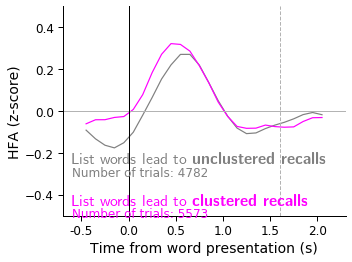

In [271]:
save_fig = 0
plot_SE = 0 # if you only want to do stats making this 0 will be much quicker since it doesn't do the ME model at each bin
plot_ME_mean = 0 # 0 for typical PSTH; 1 for ME mean; 2 for average across sub averages

# get PSTH for two of the types
plot_three = [4,6]  ## for clust v. unclust model: [5,4,6] # SCE contrast: [4,6]; SME contrast: # [5,4]
# 0 is adjacent_semantic, 1 is remote_semantic, 
# 2 is remote unclustered, 3 is dead end, 
# 4 is combined remote unclustered & dead end
# 5 is not recalled
# 6 is combined clustering (adjacent semantic and remote semantic)

bin_size = 1 # HFA already in 100 ms bins
smoothing_triangle = 5 # triangular smoothing window width
pad = int(np.floor(smoothing_triangle/2)) # factor is how many points from middle does triangle go?
text_height = -0.25

# for HFA set up PVTH stats params (encoding already has 30 bins)
bin_centers = np.arange(psth_start+0.5,psth_end)

encoding_range = range(int((-pre_encoding_time+ripple_bin_start_end[0])/sr_factor),int((-pre_encoding_time+ripple_bin_start_end[1])/sr_factor)) 
# comes to 400:1200 for 100 to 1700 of 1500 len timeseries

ME_start_array = []
ME_sub_name_array = []
ME_session_name_array = []
ME_indicator = []

# for recalled and then forgotten words
for i_array,array_num in enumerate(plot_three):
    if array_num == 0:
        temp_start_array = adj_semantic_encoding_array
#         label = 'List words lead to \\textbf{semantic transition}'        
        label = 'List words lead to \\textbf{adjacent semantic}'
        plot_color = (1,0.33,0)
    elif array_num == 1:
        temp_start_array = rem_semantic_encoding_array
        label = 'List words lead to \\textbf{remote semantic}'
        plot_color = (0,0.66,1)
    elif array_num == 2:
        temp_start_array = rem_unclustered_encoding_array
        label = 'List words lead to \\textbf{remote unclustered}'
        plot_color = (0,0.3,0)
    elif array_num == 3:
        temp_start_array = last_recall_encoding_array
        label = 'List words lead to \\textbf{dead end}'
        plot_color = (0,0,0.3)
    elif array_num == 5:
        temp_start_array = forgot_encoding_array
        label = 'List words later \\textbf{not recalled}'
        plot_color = (.66,0.33,0)
    elif array_num == 4:
        temp_start_array = superVstack(rem_unclustered_encoding_array,last_recall_encoding_array)
        label = 'List words lead to \\textbf{unclustered recalls}'
        plot_color = (0.5,0.5,0.5)
        sub_name_array4 = sub_name_array2+sub_name_array3
        sess_name_array4 = sess_name_array2+sess_name_array3
        elec_name_array4 = elec_name_array2+elec_name_array3
    elif array_num == 6:
        temp_start_array = superVstack(adj_semantic_encoding_array,rem_semantic_encoding_array)
        label = 'List words lead to \\textbf{clustered recalls}'
        if location_selected == 'ca1':
            plot_color = (0,0.66,1)
            text_height = -0.25
        elif location_selected == 'dg':
            plot_color = (1,0.33,0.66)
            text_height = -0.25
        else:
            plot_color = (1,0,1)
            text_height = -0.31
        sub_name_array6 = sub_name_array0+sub_name_array1
        sess_name_array6 = sess_name_array0+sess_name_array1
        elec_name_array6 = elec_name_array0+elec_name_array1        
    else:
        print('not using this array_num, pick another my guy')
        break
        
    sub_name_array = eval('sub_name_array'+str(array_num))
    sess_name_array = eval('sess_name_array'+str(array_num))
    elec_name_array = eval('elec_name_array'+str(array_num))
    
    # update accumulating totals for ME model
    ME_start_array = superVstack(ME_start_array,temp_start_array)
    ME_sub_name_array = np.concatenate((ME_sub_name_array,sub_name_array))
    ME_session_name_array = np.concatenate((ME_session_name_array,sess_name_array))
    ME_indicator.extend(np.repeat(i_array,len(temp_start_array)))

    if array_num == plot_three[0]:
        # for plot
        subplots(1,1,figsize=(5,3.75))
        text(-6,text_height,label,usetex=True,size=16,color=plot_color) 
        text(-6,text_height-0.06,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color,size=12)
    elif array_num == plot_three[1]:
        text(-6,text_height-0.14,label,usetex=True,size=16,color=plot_color) 
        text(-6,text_height-0.2,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color,size=12)
    else:
        text(-6,0.05,label,usetex=True,size=16,color=plot_color) 
        text(-6,0.02,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color,size=12)        
        
    # make a PSTH for HFA

    PSTH = triangleSmooth(np.mean(temp_start_array,0),smoothing_triangle)

    print('done making binned start_array with shape:')
    print(temp_start_array.shape)

    # note that output is the net ± distance from mean
    if plot_SE == True:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")   
            mean_plot,SE_plot = getMixedEffectMeanSEs(temp_start_array,sub_name_array,sess_name_array) #,elec_name_array)
        print('SEs created!')
        
    if plot_ME_mean == 1:
        PSTH = triangleSmooth(mean_plot,smoothing_triangle) # replace PSTH with means from ME model (after smoothing as usual)
    elif plot_ME_mean == 2: # average across subs first
        temp_means = []
        for sub in np.unique(sub_name_array):
            temp_means = superVstack(temp_means,np.mean(temp_start_array[np.array(sub_name_array)==sub],0))
        PSTH = triangleSmooth(np.mean(temp_means,0),smoothing_triangle)
        SE_sub_level = np.std(temp_means,0)/np.sqrt(len(temp_means))
        
    # plot
    
    if pad > 0:
        xr = bin_centers[pad:-pad]
#         binned_start_array = temp_start_array[:,pad:-pad] # remove edge bins
        PSTH = PSTH[pad:-pad] 
        if plot_SE == True:
            SE_plot = SE_plot[:,pad:-pad]
    
    plot(xr,PSTH,color=plot_color)
    if plot_SE == True:
        fill_between(xr, PSTH-SE_plot[0,:], PSTH+SE_plot[0,:], alpha = 0.3, facecolor=plot_color)
        
xticks(np.arange(pre_encoding_time+pad,encoding_time-pad+1,5),
       np.arange((pre_encoding_time+pad)/10,(encoding_time-pad+1)/10,0.5))
xlabel('Time from word presentation (s)',fontsize=14)
ylabel('HFA (z-score)',fontsize=14)
ax = plt.gca()
ax.set_ylim(-0.5,0.5)
ax.set_xlim(pre_encoding_time,encoding_time)
plot([ax.get_xlim()[0],ax.get_xlim()[1]],[0,0],linewidth=1,linestyle='-',color=(0.7,0.7,0.7))
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0))
plot([16.00,16.00],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='--',color=(0.7,0.7,0.7))
xticks(fontsize=12)
yticks(fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)   
tight_layout()

if type(location_selected)==list:
    location_selected = 'ca1dg'
        
if save_fig == 1:
    # get strings for path name for save and loading cluster data
            
    if len(plot_three)==3:
        comp_str = str(plot_three[0])+'-'+str(plot_three[1])+'-'+str(plot_three[2])
    elif len(plot_three)==2:
        comp_str = str(plot_three[0])+'-'+str(plot_three[1])

    path_name = '/home1/john/SWR/figures/ENCODING/'
    fn = os.path.join(path_name,
        'semantic_clustering_'+exp+'_'+region_name+'_'+\
        location_selected+'_'+filter_type+'_'+sub_selection+comp_str+'_'+str(plot_ME_mean)+'HFA.pdf')
    plt.savefig(fn,transparent=True)  

a=1;

In [272]:
# SCE model

save_data = 1

import statsmodels.formula.api as smf
## for the stats for each of these I'm comparing the first two to the 3rd one
# i.e. [0,1,4] is adjacent and remote semantic each vs. combined SME
# and [2,3,5] is remote unclustered and dead end each vs. not recalled
ME_ripple_rate = np.mean(ME_start_array[:,encoding_range],1)
clust_df = pd.DataFrame({'ripple_rate':ME_ripple_rate,'indicator':ME_indicator,
                        'subject':ME_sub_name_array,'session':ME_session_name_array})
vc = {'session':'0+session'}
clust_model = smf.mixedlm("ripple_rate ~ C(indicator)", clust_df, groups="subject", vc_formula=vc,re_formula="C(indicator)")
clust_results = clust_model.fit(reml=True, method='nm',maxiter=2000) 
print(clust_results.summary())
print('**p-values**:'); print(clust_results.pvalues)
print('**coefs**:'); print(clust_results.params)
print('**SEs**:'); print(clust_results.bse_fe)


# if want to save data to compare across regions

if save_data == 1:

    path_name = '/home1/john/SWR/compiled/ENCODING/'
    fn = os.path.join(path_name,
        'semantic_clustering_'+exp+'_'+region_name+'_'+\
        location_selected+'_'+filter_type+'_'+sub_selection+comp_str+'HFA.p')           
    with open(fn,'wb') as f:
        pickle.dump({'clust_df':clust_df,'comp_str':comp_str}, f)



                  Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      ripple_rate
No. Observations:       10355        Method:                  REML       
No. Groups:             52           Scale:                   2.1351     
Min. group size:        4            Likelihood:              -18681.1282
Max. group size:        1085         Converged:               Yes        
Mean group size:        199.1                                            
-------------------------------------------------------------------------
                                Coef.  Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                        0.158    0.034 4.675 0.000  0.092  0.225
C(indicator)[T.1]                0.044    0.045 0.975 0.330 -0.044  0.132
subject Var                      0.011    0.010                          
subject x C(indicator)[T.1] Cov -0.001    0.009         

### Comparing clustered and unclustered directly

In [266]:
import statsmodels.formula.api as smf

# Need to run [5,4,6] to get the correct df, since need the not recalled (5), recalled but not clustered (4), and clustered (6)

ME_ripple_rate = np.mean(ME_start_array[:,encoding_range],1)
clust_df = pd.DataFrame({'ripple_rate':ME_ripple_rate,'indicator':ME_indicator,
                        'subject':ME_sub_name_array,'session':ME_session_name_array})

# now alter this df to make a recalled column and a clustered column
clust_df['clustered'] = clust_df.indicator==2
clust_df['recalled'] = clust_df.indicator!=0

vc = {'session':'0+session'}
clust_model = smf.mixedlm("ripple_rate ~ recalled+clustered", clust_df, groups="subject", vc_formula=vc,
                          re_formula="recalled+clustered")
clust_results = clust_model.fit(reml=True, method='nm',maxiter=2000) 
print(clust_results.summary())
print('**p-values**:'); print(clust_results.pvalues)
print('**coefs**:'); print(clust_results.params)
print('**SEs**:'); print(clust_results.bse_fe)

# the ANOVA provides a nice check on the coefficients (even if the SEs are less accurate)
key = ['subject','recalled','clustered']
clust_df = clust_df.groupby(key).mean().reset_index() # averages ripple rates for correct and incorrect within each patient
OLS_model = smf.ols("ripple_rate ~ recalled+clustered", clust_df).fit()
print('Simple ANOVA:')
print(OLS_model.summary())  

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                      Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         ripple_rate
No. Observations:          36543           Method:                     REML       
No. Groups:                52              Scale:                      2.0521     
Min. group size:           35              Likelihood:                 -65077.3408
Max. group size:           2521            Converged:                  Yes        
Mean group size:           702.8                                                  
----------------------------------------------------------------------------------
                                         Coef.  Std.Err.   z   P>|z| [0.025 0.975]
----------------------------------------------------------------------------------
Intercept                                 0.075    0.019 3.912 0.000  0.037  0.113
recalled[T.True]                          0.082    0.033 2.510 0.012  0.018  0.145
clustered[T.True]          

### Comparison across regions (using data saved from last cell

In [13]:
# regions_to_compare = ['nonHPC_MTL','HPC'] # put one you want as 0 first
# locations_for_regions = ['','ca1'] # THIS NEEDS TO MATCH WITH PREVIOUS LINE
# comps = [6,4] # I saved the dataframes as clustered and unclustered comparisons so unpack from this
# compare_clust = 1 # 1 for comparing clustered, 0 for comparing unclustered

# path_name = '/home1/john/SWR/compiled/ENCODING/'

# for reg in range(len(regions_to_compare)):
#     region_name = regions_to_compare[reg]
#     location_selected = locations_for_regions[reg]
#     comp_str = str(comps[0])+'-'+str(comps[1])
#     fn = os.path.join(path_name,
#         'semantic_clustering_'+exp+'_'+region_name+'_'+\
#         location_selected+'_'+filter_type+'_'+sub_selection+comp_str+'.p') 

#     with open(fn,'rb') as f:
#         dat = pickle.load(f)
#         print(len(dat['clust_df'].query('indicator == '+str(1-compare_clust))))
#     if reg == 0:
#         comb_df = dat['clust_df']
#     elif reg == 1:
#         comb_df = comb_df.query('indicator == '+str(1-compare_clust)) # keep only clust ones
#         temp_df = dat['clust_df'].query('indicator == '+str(1-compare_clust)) # keep only clust ones
#         temp_df.indicator = np.repeat(compare_clust,len(temp_df))
#         comb_df = pd.concat([comb_df,temp_df],ignore_index=True)
        
# vc = {'session':'0+session'}
# reg_model = smf.mixedlm("ripple_rate ~ indicator", comb_df, groups="subject", vc_formula=vc,re_formula="indicator")
# reg_results = reg_model.fit(reml=True, method='nm',maxiter=2000) 
# print(reg_results.summary())
# print('**p-values**:'); print(reg_results.pvalues)
# if compare_clust == 0:
#     coefs = -1*reg_results.params
# else:
#     coefs = reg_results.params
# print('**coefs**:'); print(coefs)
# print('**SEs**:'); print(reg_results.bse_fe)
# a=1;

# ^^this version didn't make sense...make the dataframe for the indicator X region interaction instead

import statsmodels.formula.api as smf

regions_to_compare = ['nonHPC_MTL','HPC'] # put one you want as 0 first
locations_for_regions = ['','ca1'] # THIS NEEDS TO MATCH WITH PREVIOUS LINE
comps = [6,4] # I saved the dataframes as clustered and unclustered comparisons so unpack from this

path_name = '/home1/john/SWR/compiled/ENCODING/'

for reg in range(len(regions_to_compare)):
    region_name = regions_to_compare[reg]
    location_selected = locations_for_regions[reg]
    comp_str = str(comps[0])+'-'+str(comps[1])
    fn = os.path.join(path_name,
        'semantic_clustering_'+exp+'_'+region_name+'_'+\
        location_selected+'_'+filter_type+'_'+sub_selection+comp_str+'.p') 

    with open(fn,'rb') as f:
        dat = pickle.load(f)
        print(len(dat['clust_df']))
    if reg == 0:
        comb_df = dat['clust_df']
        comb_df['region'] = np.zeros(len(comb_df))
    elif reg == 1:
        temp_df = dat['clust_df']
        temp_df['region'] = np.ones(len(temp_df))
        comb_df = pd.concat([comb_df,temp_df],ignore_index=True)
        
vc = {'session':'0+session'}
comb_df.indicator = 1-comb_df.indicator # so clustered is now 1
reg_model = smf.mixedlm("ripple_rate ~ indicator*region", comb_df, groups="subject", vc_formula=vc)
reg_results = reg_model.fit(reml=True, method='nm',maxiter=2000) 
print(reg_results.summary())
print('**p-values**:'); print(reg_results.pvalues)
coefs = reg_results.params
print('**coefs**:'); print(coefs)
print('**SEs**:'); print(reg_results.bse_fe)
a=1;

45199
32874
          Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: ripple_rate
No. Observations:  78073   Method:             REML       
No. Groups:        249     Scale:              0.2538     
Min. group size:   8       Likelihood:         -57567.0133
Max. group size:   2580    Converged:          Yes        
Mean group size:   313.5                                  
----------------------------------------------------------
                 Coef. Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        0.203    0.009 23.267 0.000  0.186  0.220
indicator        0.005    0.005  0.956 0.339 -0.005  0.014
region           0.142    0.006 22.434 0.000  0.130  0.154
indicator:region 0.026    0.007  3.533 0.000  0.012  0.041
session Var      0.014    0.003                           

**p-values**:
Intercept           9.666361e-120
indicator            3.392701e-01
region              1.832894e-1

## same idea but comparing SCE v. recall and p(clustering) plots between regions

In [19]:
import statsmodels.formula.api as smf

regions_to_compare = ['nonHPC_MTL','HPC'] # put one you want as 0 first
locations_for_regions = ['','dg'] # THIS NEEDS TO MATCH WITH PREVIOUS LINE

path_name = '/home1/john/SWR/compiled/ENCODING/'

for reg in range(len(regions_to_compare)):
    region_name = regions_to_compare[reg]
    location_selected = locations_for_regions[reg]
    fn = '/home1/john/SWR/figures/subject-level_plots/SCE_v_recall_'+exp+'_'+region_name+'_'+\
        location_selected+'_'+filter_type+'_'+sub_selection+'.p'

    with open(fn,'rb') as f:
        dat = pickle.load(f)
        print(len(dat['sess_df']))
    if reg == 0:
        comb_df = dat['sess_df']
        comb_df['region'] = np.zeros(len(comb_df))
    elif reg == 1:
        temp_df = dat['sess_df']
        temp_df['region'] = np.ones(len(temp_df))
        comb_df = pd.concat([comb_df,temp_df],ignore_index=True)
        
vc = {'session':'0+session'}

reg_model = smf.mixedlm("delta_ripple_rate ~ avg_recall_num*region", comb_df, groups="subject", vc_formula=vc)
reg_results = reg_model.fit(reml=True, method='nm',maxiter=2000) 
print('****Avg_recall_num X region model:****')
print(reg_results.summary())
print('**p-values**:'); print(reg_results.pvalues)
coefs = reg_results.params
print('**coefs**:'); print(coefs)
print('**SEs**:'); print(reg_results.bse_fe)


reg_model = smf.mixedlm("delta_ripple_rate ~ prop_semantic*region", comb_df, groups="subject", vc_formula=vc)
reg_results = reg_model.fit(reml=True, method='nm',maxiter=2000) 
print('****Prop_semantic X region model****:')
print(reg_results.summary())
print('**p-values**:'); print(reg_results.pvalues)
coefs = reg_results.params
print('**coefs**:'); print(coefs)
print('**SEs**:'); print(reg_results.bse_fe)
a=1;

sess_df = pd.DataFrame({'delta_ripple_rate':sess_delta,'avg_recall_num':sess_recall_num,
                        'session':sess_sessions,'subject':sess_subjects,'prop_semantic':sess_prop_semantic})

169
102


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


****Avg_recall_num X region model:****
             Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: delta_ripple_rate
No. Observations:  271     Method:             REML             
No. Groups:        98      Scale:              0.0101           
Min. group size:   1       Likelihood:         223.8012         
Max. group size:   11      Converged:          Yes              
Mean group size:   2.8                                          
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.016    0.019  0.849 0.396 -0.021  0.054
avg_recall_num        -0.001    0.004 -0.326 0.744 -0.010  0.007
region                -0.071    0.036 -1.977 0.048 -0.142 -0.001
avg_recall_num:region  0.023    0.008  2.940 0.003  0.008  0.038
session Var            0.000    0.010                           


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
